## Predicting pressure field

In [ ]:
# This does not work, have not found a way to calculate the pressure field for a velocity field (other than incompressible bernoulli)

# Also, not sure why this would be useful

In [53]:
#imports
import jax
import jax.numpy as jnp
from jax import value_and_grad

from jax_cfd.ml import towers
import jax_cfd.ml.train_utils as train_utils
from jax_cfd.base.finite_differences import divergence
import jax_cfd.base as cfd
import jax_cfd.base.grids as grids

import haiku as hk
import gin
import numpy as np
import xarray
import random

import pickle
from diego_model_utils import SaveObject, forward_pass_module

import matplotlib.pyplot as plt
import seaborn

In [13]:
# import data
file_name = '256x64_150_seconds_inner_1'
data = xarray.open_dataset(f'../../creating_dataset/datasets/'+ file_name +'.nc', chunks={'time': '100MB'})

In [14]:
# split by timestamps
x_shape = len(data.x)
y_shape = len(data.y)
high_def = []
for i in range(int(len(data.time))):
    this_time = jnp.dstack([
        jnp.array([data.u.isel(time = i)]).reshape(x_shape, y_shape),
        jnp.array([data.v.isel(time = i)]).reshape(x_shape, y_shape)
    ])
    high_def.append(this_time)

In [15]:
#warm up time (may want to discard initial stages of simulation since not really representative of turbulent flow?)
dt = float(data.time[0].values)

outer_steps = len(data.time.values)

inner_steps = (data.time[1].values-data.time[0].values)/dt

total_sim_time = outer_steps*inner_steps*dt
print("dt: \t\t" + str(dt))
print("outer_steps: \t" + str(outer_steps))
print("inner_steps: \t" + str(inner_steps))
print("total_sim_time: " + str(total_sim_time))

warm_up = 15 #seconds
warm_index = int(warm_up/total_sim_time * outer_steps // 1)
print("removed points: " + str(warm_index))
high_def = high_def[warm_index:]

dt: 		0.015625
outer_steps: 	9600
inner_steps: 	1.0
total_sim_time: 150.0
removed points: 960


In [16]:
high_def = high_def[0::20]

In [17]:
np.shape(high_def)

(432, 256, 64, 2)

In [18]:
print("Training dataset shape: ")#(frames, x, y, input channels)
print("\t" + str(np.shape(high_def)))



Training dataset shape: 
	(432, 256, 64, 2)


In [19]:
originalMax = np.max(high_def)
originalMin = (np.min(high_def))
print(originalMin,originalMax)

-0.77263814 1.0149648


In [20]:
# scale velocities to beetween zero and one
def scale(input, min=0, max=1):
    
    if min>max:
        raise(ValueError("Min and max may be the wrong way around"))
    
    if min<0:
        og_min = min
        max += -min
        min = 0

    
    input += (min-np.min(input))
    input /= (np.max(input)/max)
    
    try:
        input += og_min
    except:
        pass
    return input


def scaleAllVelocities(high_def,allVels=False):
    
    scaled = []
    for vels in high_def:
        both_vels = []
        for vel in vels:
            vel = scale(vel,min=0,max=1)
            both_vels.append(vel)
        scaled.append(both_vels)
    return scaled

In [21]:
def scaleAllTimes(data):
    out = []
    for i in range(len(data)):
        this_time = jnp.dstack([
            scale(data[i][:,:,0]),
            scale(data[i][:,:,1])
        ])
        
        
        out.append(this_time)
    return out

In [22]:
# scaled_high_def = scaleAllVelocities(high_def,allVels=True) #scales each frame from 0 to 1
scaled_high_def = scaleAllTimes(high_def) #scales all timesteps to same max and min

In [23]:
def increaseSize(input, factor):
    w,h = np.shape(input)
    output = np.zeros((w*factor,h*factor))
    
    for width in range(w*factor):
        for height in range(h*factor):
            output[width][height] = input[width//factor][height//factor]
    return output


def decreaseSize(input,factor):
    w,h = np.shape(input)
    if w%factor != 0 or h%factor != 0:
        raise(AssertionError("Non-compatible input shape and downsample factor"))
    
    output = np.zeros((int(w/factor),int(h/factor)))
    
    for width in range(w):
        for height in range(h):
            output[width//factor][height//factor] += input[width][height]
    output /= factor**len(np.shape(output))
    return output

def downsampleHighDefVels(high_def,factor):
    low_def = []
    for vels in high_def:
        both_vels = []
        for vel in vels:
            vel = decreaseSize(vel,factor)

            vel = increaseSize(vel,factor)
            both_vels.append(vel)
        low_def.append(both_vels)
    return low_def

def downsampleHighDefVelsNumpy(high_def,factor):
    """
    Same as downsampleHighDefVels but running the resizings on numpy arrays
    due to performance issues with these funcitions and DeviceArrays
    """
    low_def = []
    for vels in high_def:
        
        u = decreaseSize(np.array(vels[:,:,0]),factor) #output is a np.array
        u = jnp.array(increaseSize(u,factor)) #output is a DeviceArray
        
        v = decreaseSize(np.array(vels[:,:,1]),factor) #output is a np.array
        v = jnp.array(increaseSize(v,factor)) #output is a DeviceArray
        
        low_def.append(jnp.dstack([
            u,
            v
        ]))
    return low_def

In [24]:
#converting lists of images to DeviceArray with correct shape

def convertListToDeviceArray(list):
    new_list = []
    for i in range(len(list)):

        new_list.append(
            jnp.dstack([
                jnp.array(list[i][0]),
                jnp.array(list[i][1])]
            )
        )
    return jnp.array(new_list)



In [25]:
#split into train and test

split = 0.8
split = int(len(scaled_high_def)*split//1)
random.shuffle(high_def)

factor = 4



%time scaled_low_def = downsampleHighDefVelsNumpy(scaled_high_def,factor)
#conv_scaled_high_def = convertListToDeviceArray(scaled_high_def)
#conv_scaled_low_def = convertListToDeviceArray(scaled_low_def)

conv_scaled_high_def = scaled_high_def
conv_scaled_low_def = scaled_low_def

X_train = conv_scaled_low_def[:split]
Y_train = conv_scaled_high_def[:split]

X_test = conv_scaled_low_def[split:]
Y_test = conv_scaled_high_def[split:]



CPU times: user 16.3 s, sys: 19.6 ms, total: 16.3 s
Wall time: 16.4 s


In [38]:
def printAllShapes(*things):
    for thing in things:
        print(np.shape(thing))

printAllShapes(X_train,Y_train, X_test,Y_test)

(345, 256, 64, 2)
(345, 256, 64, 2)
(87, 256, 64, 2)
(87, 256, 64, 2)


In [85]:
test_data = X_train[0]
size = (256,64)
domain = ((0, 8), (0, 2))



grid = grids.Grid(size, domain = domain)


In [96]:
grid

Grid(shape=(256, 64), step=(0.03125, 0.03125), domain=((0.0, 8.0), (0.0, 2.0)))

In [116]:
shape = grid.shape
step= grid.step
domain = grid.domain

factor = 4
mylist = []
for i in range(len(shape)):
    mylist.append(np.arange(domain[i][0],domain[i][1],step[i]*factor))

In [117]:
np.shape(mylist[1])

(16,)

In [118]:
v_test = (base.grids.GridVariable(array = base.grids.GridArray(data = test_data[:,:,0],offset=(1.0, 0.5),grid=grid),
                                    bc = cfd.boundaries.channel_flow_boundary_conditions(ndim=1),
                                    
                                ),
          base.grids.GridVariable(array = base.grids.GridArray(data = test_data[:,:,1],offset=(0.5,1.0),grid=grid),
                                    bc = cfd.boundaries.channel_flow_boundary_conditions(ndim=1),
                                    
                                )
         )


In [119]:
result = base.pressure.projection(v_test)

(2, 256, 64)

<AxesSubplot: >

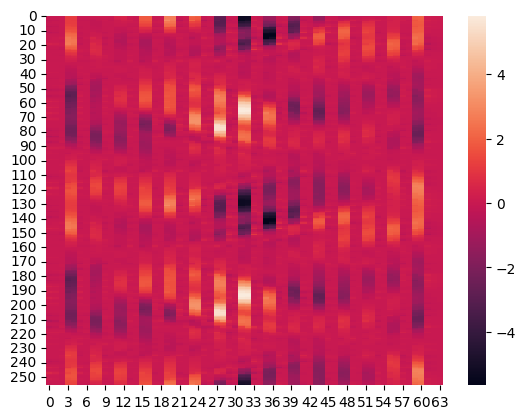

In [115]:
seaborn.heatmap(gradient[1])

<AxesSubplot: >

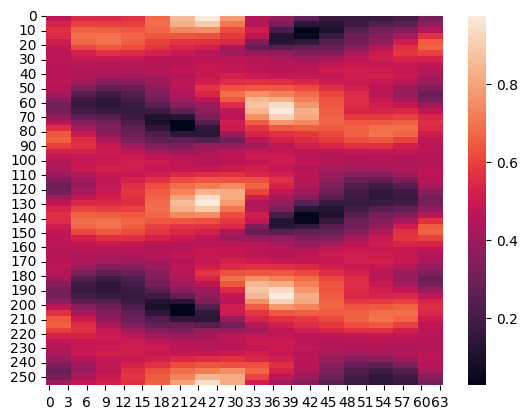

In [90]:
seaborn.heatmap(X_train[0][:,:,0])